# Face Expression Detection

## Libraries



In [1]:
import os
import glob
import random
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import keras
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

from google.colab import files

In [2]:
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [6]:
font_size = 16

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.25
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1.2

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['tab:blue', 'tab:red', 'black']) 

<br>

## Running GPU on Colab

Ensure that GPU is running on this Colab notebook by following below steps.

1. Colab Menu: Select "Runtime"
2. "Change runtime type"
3. Select "Hardware Accelerator" = GPU
4. Save

In [4]:
# confirm that GPU is running
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

<br>

## Get Data

In [9]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [10]:
!kaggle datasets download jonathanoheix/face-expression-recognition-dataset

 80% 97.0M/121M [00:03<00:00, 25.4MB/s]
100% 121M/121M [00:03<00:00, 33.2MB/s] 


In [11]:
%%capture
!unzip face-expression-recognition-dataset.zip

In [12]:
!kaggle datasets download shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 227MB/s]


In [13]:
%%capture
!unzip ckplus.zip

In [14]:
!rm /content/face-expression-recognition-dataset.zip
!rm /content/ckplus.zip

In [15]:
%rm -rf /content/images/images
%rm -rf /content/ck

In [16]:
!mv "/content/CK+48/anger"/* "/content/images/train/angry"
!mv "/content/CK+48/disgust"/* "/content/images/train/disgust"
!mv "/content/CK+48/fear"/* "/content/images/train/fear"
!mv "/content/CK+48/happy"/* "/content/images/train/happy"
!mv "/content/CK+48/sadness"/* "/content/images/train/sad"
!mv "/content/CK+48/surprise"/* "/content/images/train/surprise"

<br>

## Data Visualisation

In [17]:
base_path = r'/content/images/'

In [18]:
emotions_list = os.listdir(base_path + 'train/')
emotions_list = sorted(emotions_list)

print('Emotions:\n', *emotions_list, sep='\n  ')

Emotions:

  angry
  disgust
  fear
  happy
  neutral
  sad
  surprise


In [19]:
num_classes = len(emotions_list)

In [20]:
print('Number of images in folders:')
print('     Train: ', len(glob.glob("/content/images/train/*/*.jpg")))
print('Validation: ', len(glob.glob("/content/images/validation/*/*.jpg")))

Number of images in folders:
     Train:  28821
Validation:  7066


In [21]:
path = base_path + 'train/'
number_of_files = [len(os.listdir(path + '{}/'.format(emotion))) for emotion in emotions_list]

df = pd.DataFrame({
    'Emotion': [emotion.title() for emotion in emotions_list],
    'Count': number_of_files
})
df.sort_values(by='Count', ascending=False, inplace=True)

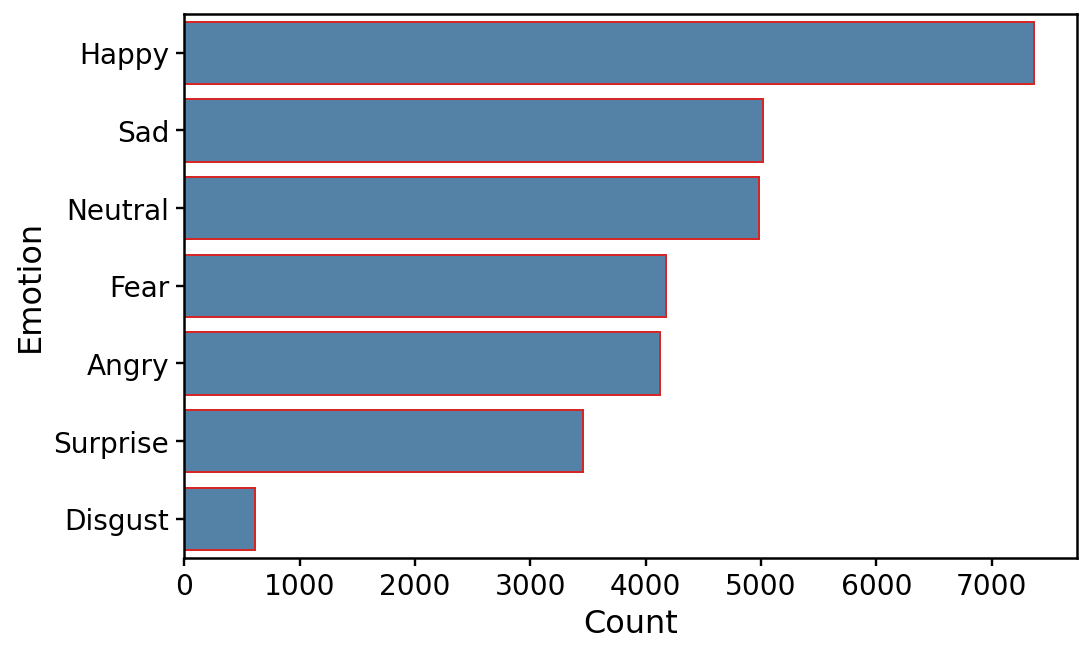

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.barplot(y='Emotion', x='Count', color='steelblue', edgecolor='tab:red', data=df)

plt.show()

In [23]:
img_depth = 1
img_width, img_height = 48, 48

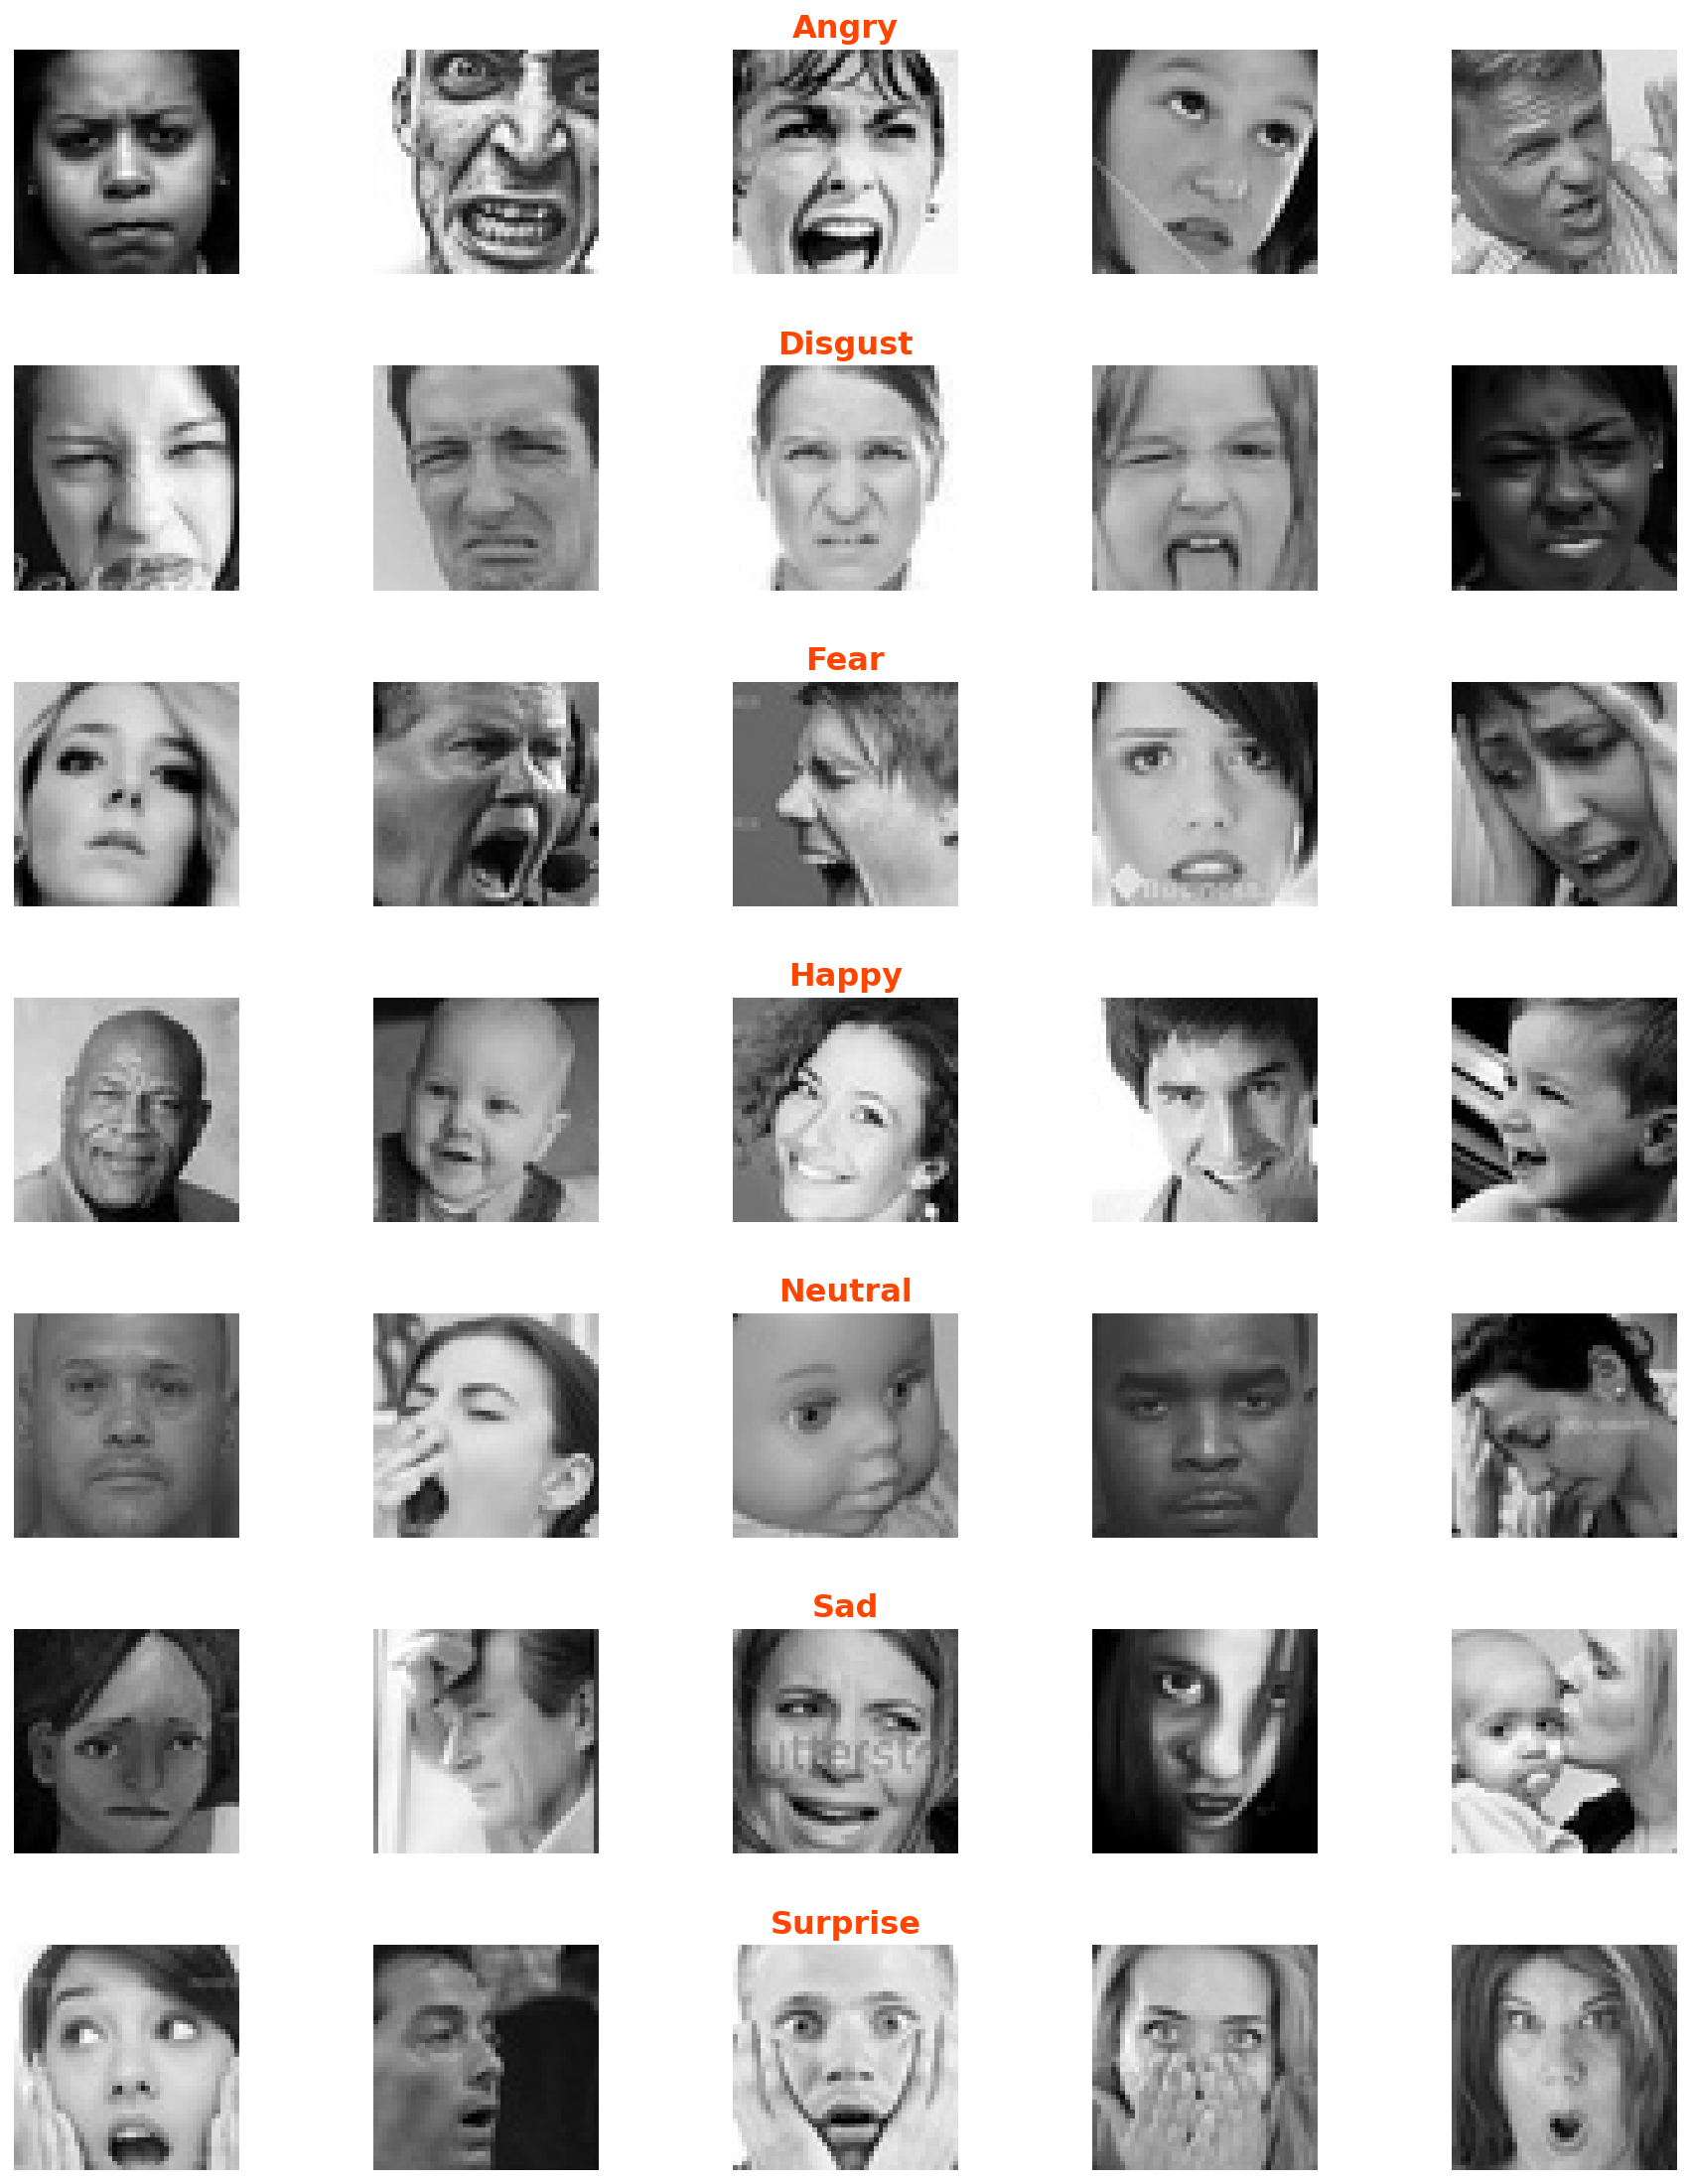

In [115]:
fig = plt.figure(0, figsize=(15, 20))

index = 1
for emotion in emotions_list:
    path = base_path + 'train/{}'.format(emotion)
    file_numbers = os.listdir(path)
    random_files = np.random.choice(file_numbers, size=5, replace=False)

    for i, random_file in enumerate(random_files):
        img = load_img(path= base_path + 'train/{}/{}'.format(emotion, random_file),
                       target_size=(img_width, img_height))

        plt.subplot(7, 5, index)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 2: plt.title(emotion.title(), color='orangered', weight='bold')
        index += 1

fig.subplots_adjust(wspace=0.6)
plt.show()

<br>

## Image Augmentation

In [25]:
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(base_path + 'train',
                                                    target_size=(img_width, img_height),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + 'validation',
                                                    target_size=(img_width, img_height),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 29748 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


<br>

## Creating the Model

In [26]:
model = Sequential(name='DCNN')

model.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 input_shape=(img_width, img_height, img_depth),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal',
                 name='conv2d_1'))
model.add(BatchNormalization(name='batchnorm_1'))

model.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal',
                 name='conv2d_2'))
model.add(BatchNormalization(name='batchnorm_2'))
    
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(Conv2D(filters=128,
                 kernel_size=(3, 3),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal',
                 name='conv2d_3'))
model.add(BatchNormalization(name='batchnorm_3'))

model.add(Conv2D(filters=128,
                 kernel_size=(3, 3),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal',
                 name='conv2d_4'))
model.add(BatchNormalization(name='batchnorm_4'))
    
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(Conv2D(filters=256,
                 kernel_size=(3, 3),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal',
                 name='conv2d_5'))
model.add(BatchNormalization(name='batchnorm_5'))

model.add(Conv2D(filters=256,
                 kernel_size=(3, 3),
                 activation='elu',
                 padding='same',
                 kernel_initializer='he_normal',
                 name='conv2d_6'))
model.add(BatchNormalization(name='batchnorm_6'))
    
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Flatten(name='flatten'))
        
model.add(Dense(128,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'))
model.add(BatchNormalization(name='batchnorm_7'))
    
model.add(Dropout(0.6, name='dropout_4'))
    
model.add(Dense(num_classes,
                activation='softmax',
                name='out_layer'))
   
model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<br>

## Compiling the Model

In [28]:
# optim = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
optim = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

<br>

## Training the Model

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.0001,
                               patience=11,
                               verbose=1,
                               restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                                 factor=0.5,
                                 patience=7,
                                 verbose=1,
                                 min_lr=1e-7)

callbacks = [early_stopping, lr_scheduler]

In [31]:
batch_size = 32
epochs = 100

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


929/929 [==============================] - 63s 55ms/step - loss: 2.0965 - accuracy: 0.2275 - val_loss: 1.6458 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 2/100
929/929 [==============================] - 52s 56ms/step - loss: 1.6752 - accuracy: 0.3390 - val_loss: 1.5053 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 3/100
929/929 [==============================] - 50s 53ms/step - loss: 1.5033 - accuracy: 0.4220 - val_loss: 1.3409 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 4/100
929/929 [==============================] - 51s 55ms/step - loss: 1.4058 - accuracy: 0.4625 - val_loss: 1.4935 - val_accuracy: 0.5246 - lr: 0.0010
Epoch 5/100
929/929 [==============================] - 48s 52ms/step - loss: 1.3404 - accuracy: 0.4889 - val_loss: 1.2151 - val_accuracy: 0.5328 - lr: 0.0010
Epoch 6/100
929/929 [==============================] - 48s 51ms/step - loss: 1.2910 - accuracy: 0.5096 - val_loss: 1.1373 - val_accuracy: 0.5716 - lr: 0.0010
Epoch 7/100
929/929 [==============================] - 47s 51ms/

<br>

## Learning Curves

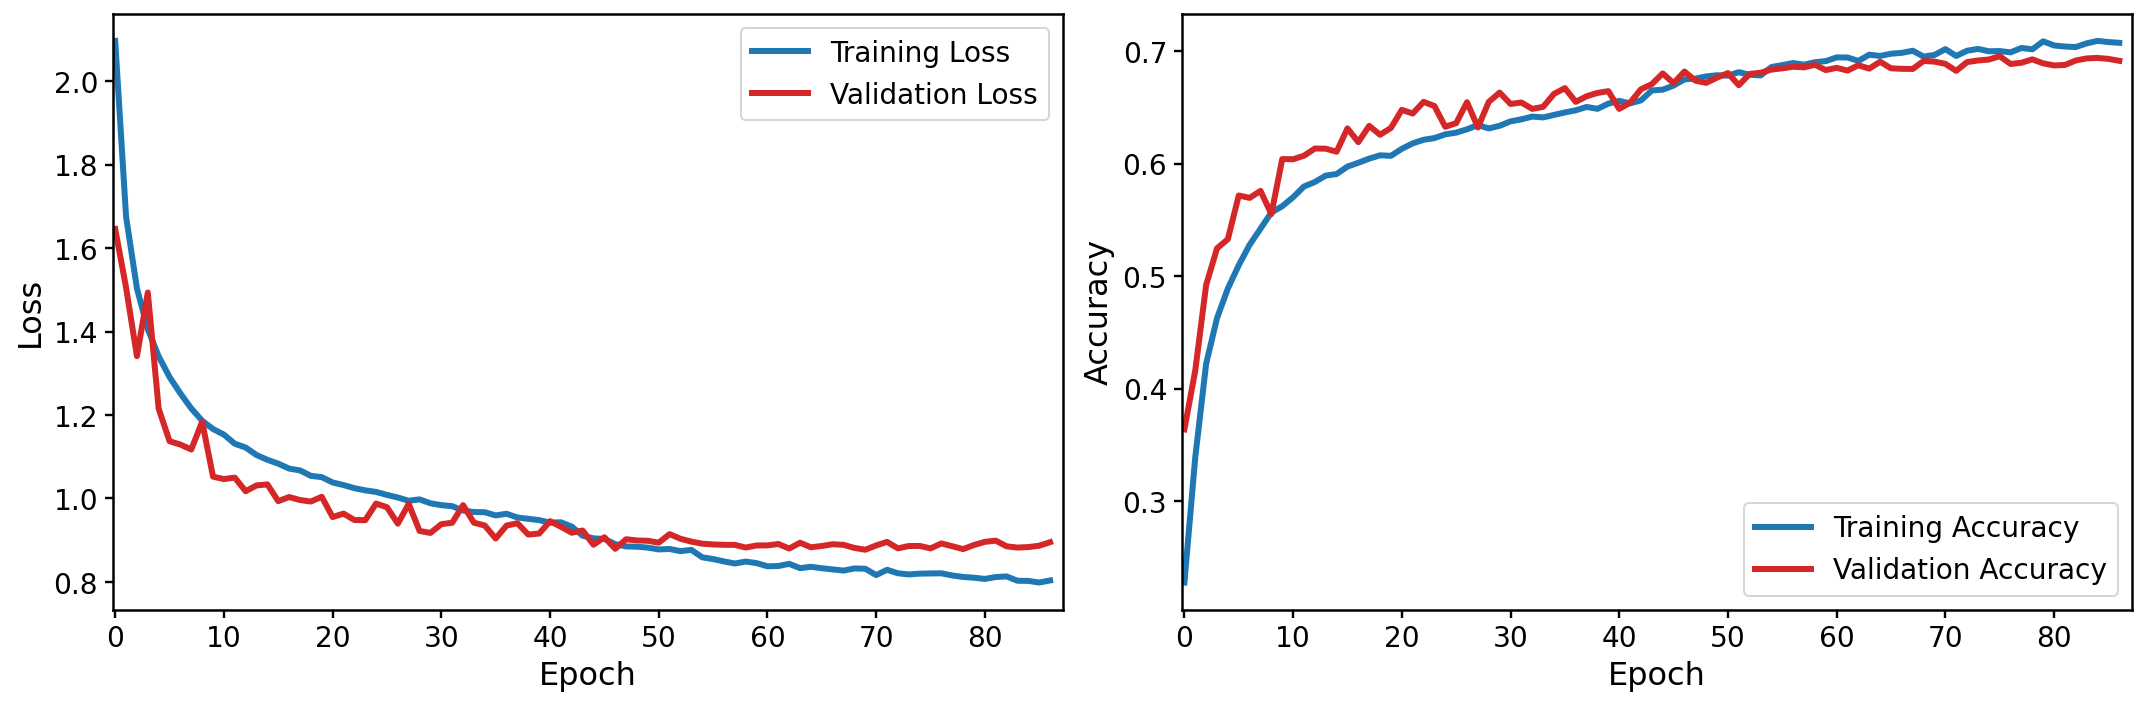

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

for ax in [ax1, ax2]:
  ax.set_xlabel('Epoch')
  ax.set_xlim(left=-0.2, right=len(history.history['loss']) + 0.2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

<br>

## Predictions

In [37]:
model.save('my_model.h5')

In [38]:
loaded_model = keras.models.load_model('/content/my_model.h5')

In [55]:
predictions = loaded_model.predict_generator(generator=validation_generator)
classes = validation_generator.class_indices.keys()

print(classes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])


In [56]:
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes

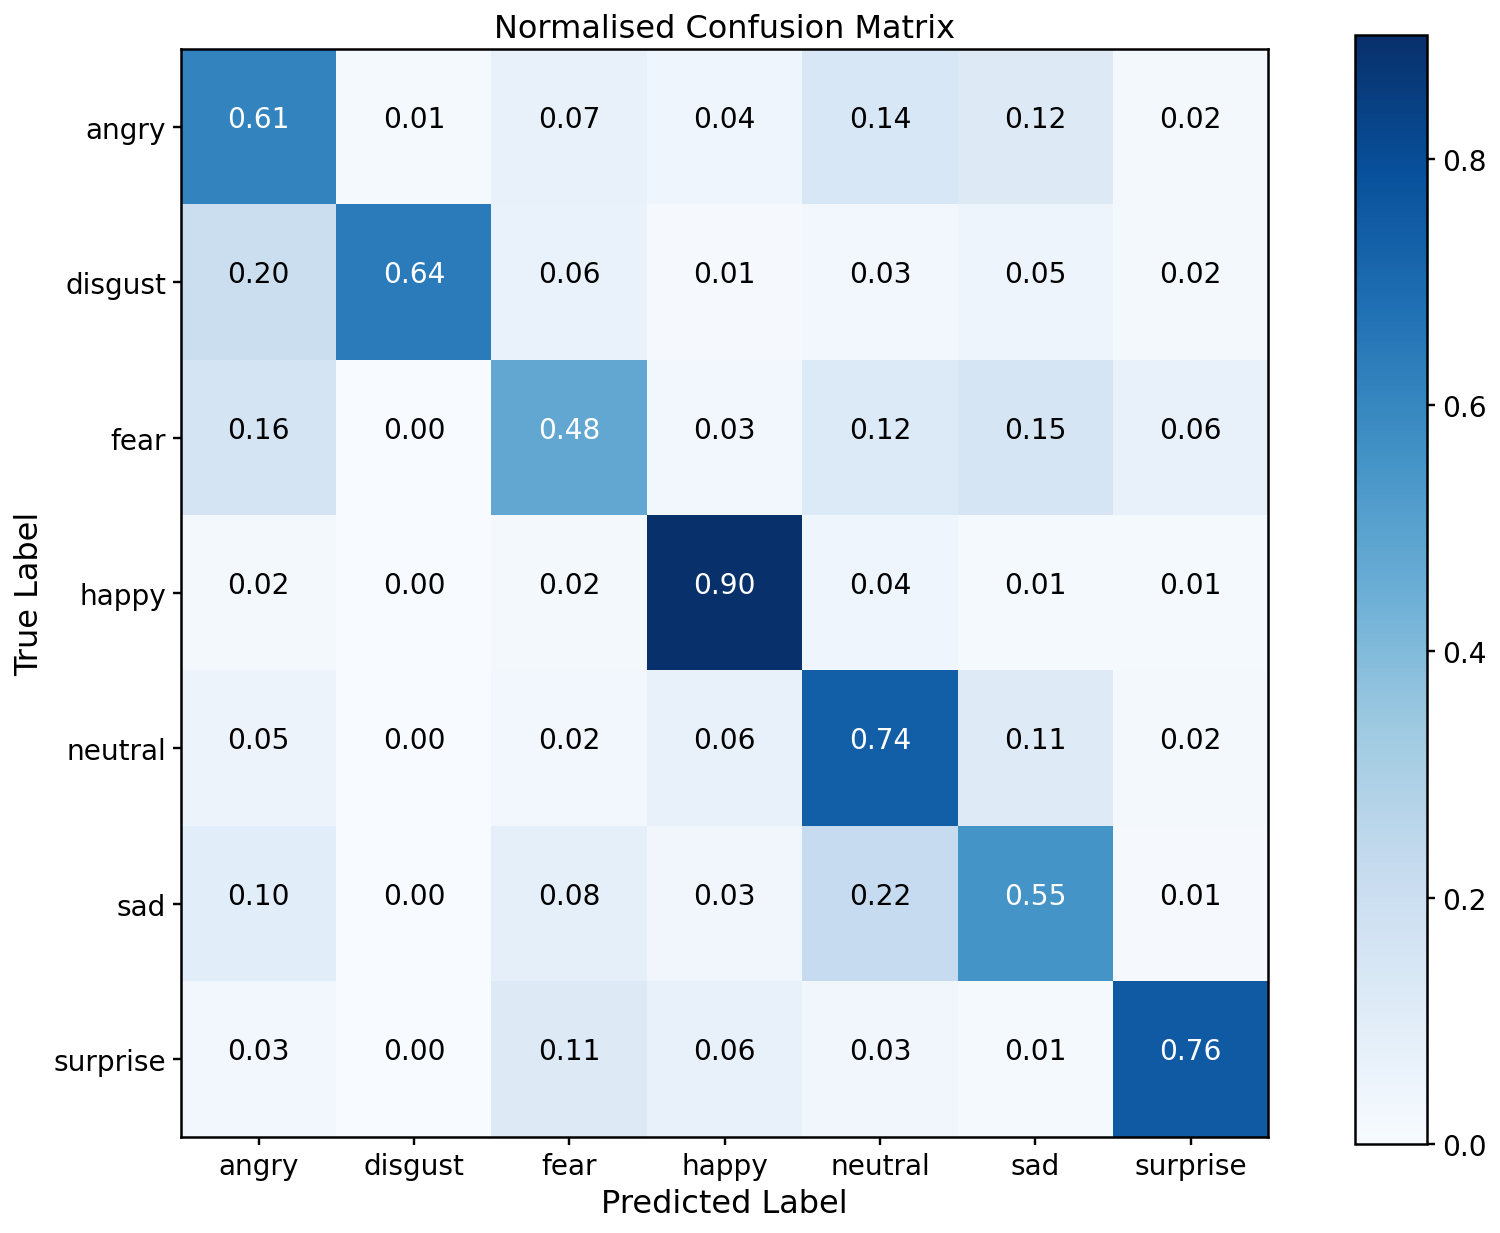

In [114]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))

im=ax.imshow(cm, interpolation='nearest', cmap='Blues')

ax.set(title='Normalised Confusion Matrix',
       xlabel='Predicted Label',
       ylabel='True Label')

tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=0)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(x=j,
           y=i,
           s=format(cm[i, j], '.2f'),
           fontsize=14,
           ha='center',
           color='w' if cm[i, j] > thresh else 'k')

cax = plt.axes([0.95, 0.12, 0.05, 0.77])
plt.colorbar(mappable=im, cax=cax)

plt.show()

<br>

---

<br>